In [1]:
import os
from os import listdir
from os.path import isfile, join

import pandas as pd
from itertools import islice
import numpy as np

from skimage.external import tifffile
from skimage.external.tifffile import imread

import matplotlib.pyplot as plt

import ipywidgets as widgets

import random

In [2]:
bigDir = r'Z:\CookLab\Liu\20190816_organizedData_MCM_loading'

In [3]:
file=f'{bigDir}\\20191202_new dataset\\signals_new_v5.csv'
cellData=pd.read_csv(file)

In [4]:
het_percentile=20

In [32]:
def randomHetMask(cellData):
    i=0

    # Progress Bar
    progBar=widgets.IntProgress(
        value=i,
        min=0,
        max=len(cellData),
        step=1,
        description='Progress:',
        orientation='horizontal'
    )
    display(progBar)

    for i,myCell in islice(cellData.iterrows(), i,None):

        # create folder to store this percentile data if it doesn't exist yet
        newSegFolder = os.path.dirname(myCell.path).replace('data_tiff',f'segmentation_{het_percentile}')

        try:
            os.mkdir(newSegFolder)
        except:
            pass

        # create folder to store random percentile data
        newSegScrFolder = os.path.dirname(myCell.path).replace('data_tiff',f'segmentation_scrambled_{het_percentile}')

        try:
            os.mkdir(newSegScrFolder)
        except:
            pass


        # open tiff image of a cell
        try:
            myImage=imread(myCell.path) 
        except:
            myCell.path=myCell.path.replace('.tif','.tiff')
            myImage=imread(myCell.path)    
        myChannel = myImage[:, 1, :, :] #2nd channel is hetChrom (as stained by HP1B or H3K9Me3)

        # open nucleus mask
        nucleusMaskPath=myCell.path
        nucleusMaskPath=nucleusMaskPath.replace('data_tiff','segmentation_nucleus_Otsu')
        nucleusMaskPath=nucleusMaskPath.replace('.tif','_nucleus.tif')
        try:
            nucleusMask=imread(nucleusMaskPath)
        except:
            nucleusMaskPath=nucleusMaskPath.replace('.tiff','.tif')
            nucleusMask=imread(nucleusMaskPath)

        # make nucleus mask binary
        nucleusMask = nucleusMask.astype(bool)

        # clean image
        myNucleus = myChannel[nucleusMask]

        # find threshold
        myPercentile = np.nanpercentile(myNucleus, (100-het_percentile)) 

        # threshold
        myHetMask=np.zeros(myChannel.shape).astype('bool')
        myHetMask[myChannel > myPercentile] = 1

        # clean from elements outside the nucleus
        cleanNucleusMask=~nucleusMask
        myHetMask[cleanNucleusMask]=0
        cleanHetMask = ~myHetMask


        # scrambled segmentation
        scrMask=np.random.randint(0,10,size=nucleusMask.shape)
        scrMask[scrMask>(het_percentile/10)]=0
        scrMask=scrMask.astype(bool)
        scrMask[cleanNucleusMask]=0 
        cleanScrMask=~scrMask

        # save scrambled segmentation mask
        maskFile = os.path.basename(myCell.path).replace('.tif',f'_scrambled.tif')
        tifffile.imsave(os.path.join(newSegScrFolder,maskFile), scrMask.astype('uint8'))    

        progBar.value=progBar.value+1

In [29]:
cell=cellData.loc[0,:]
path=cell.path.replace('data_tiff',f'segmentation_scrambled_20')
path=path.replace('.tif','_scrambled.tif')

In [30]:
hetmask=imread(path)

<IPython.core.display.Javascript object>


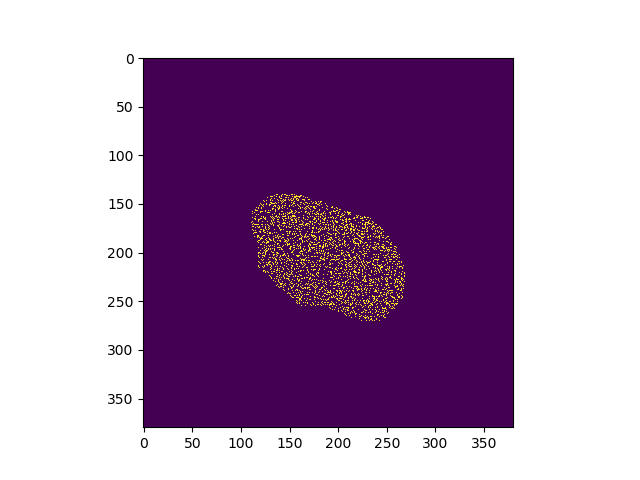

In [31]:
%matplotlib notebook
plt.imshow(hetmask[10])

In [5]:
file1=f'{bigDir}\\20200203_new data\\cellinfo_200203_v10.csv'
data1=pd.read_csv(file1)

In [34]:
randomHetMask(data1)

IntProgress(value=0, description='Progress:', max=146)

In [3]:
file2=f'{bigDir}\\20200217_geminin\\200217_cellinfo_v8.csv'
data2=pd.read_csv(file2)

In [36]:
randomHetMask(data2)

IntProgress(value=0, description='Progress:', max=145)

In [5]:
def create_het_mask_erosion (name, data,percentage):
    if name=="new":
        hp1=1
    else:
        hp1=0

    i=0
    het_percentile=percentage
    # Progress Bar
    progBar=widgets.IntProgress(
        value=i,
        min=0,
        max=len(data),
        step=1,
        description='Progress:',
        orientation='horizontal'
    )
    display(progBar)

    for i,myCell in islice(data.iterrows(), i,None):

        # create folder to store this percentile (inner and outer) data if it doesn't exist yet
        newSegFolder = os.path.dirname(myCell.path).replace('data_tiff',f'segmentation_scrambled_{het_percentile}_erosion')

        try:
            os.mkdir(newSegFolder)
        except:
            pass

        try:
            os.mkdir(newResultsFolder)
        except:
            pass


        # open tiff image of a cell
        try:
            myImage=imread(myCell.path)    
        except:
            myCell.path=myCell.path.replace('.tif','.tiff')
            myImage=imread(myCell.path)    


        myChannel = myImage[:, 1, :, :] #2nd channel is hetChrom (as stained by HP1B or H3K9Me3)

        ## openning nucleus masks
        nucleusMaskPath=myCell.path
        nucleusMaskPath=nucleusMaskPath.replace('data_tiff','erosion_nuc_mask')
        nucouterpath=nucleusMaskPath.replace('.tif','_eroded_9^5_outer_mask_20.tif')
        nucinnerpath=nucleusMaskPath.replace('.tif','_eroded_9^5_inner_mask_20.tif')
        outernuc=imread(nucouterpath)
        outernuc=outernuc.astype(bool)
        innernuc=imread(nucinnerpath)
        innernuc=innernuc.astype(bool)

        ## opening heterochromatin mask
        hetPath=myCell.path
        hetPath=hetPath.replace('data_tiff',f'segmentation_scrambled_{percentage}')
        hetPath=hetPath.replace('.tif','_scrambled.tif')
        het=imread(hetPath)
        het=het.astype(bool)

        ## masking heterochromatin with inner nuc mask
        het_inner=het.copy()
        het_inner=het_inner.astype(bool)
        het_inner[~innernuc]=0

        ## masking heterochromatin with outer nuc mask
        het_outer=het.copy()
        het_outer=het_outer.astype(bool)
        het_outer[~outernuc]=0

        ## save segmentation mask
        maskFile = os.path.basename(myCell.path).replace('.tif',f'_hetChrom_inner.tif')
        tifffile.imsave(os.path.join(newSegFolder,maskFile), het_inner.astype('uint8'))
        maskFile = os.path.basename(myCell.path).replace('.tif',f'_hetChrom_outer.tif')
        tifffile.imsave(os.path.join(newSegFolder,maskFile), het_outer.astype('uint8'))


        progBar.value=progBar.value+1

def create_eu_mask(name,data,percentage):
    ## based on the name give as a parameter, selecting the channel 
    ### hp1beta channel is 2 in new dataset and 1 in original dataset

    if name=="new":
        hp1=1
    else:
        hp1=0

    het_percentile=percentage
    # Progress Bar
    i=0
    progBar=widgets.IntProgress(
        value=i,
        min=0,
        max=len(data),
        step=1,
        description='Progress:',
        orientation='horizontal'
    )
    display(progBar)

    for i,myCell in islice(data.iterrows(), i,None):

        ## create folder to store this percentile data if it doesn't exist yet
        newSegFolder = os.path.dirname(myCell.path).replace('data_tiff',f'segmentation_scrambled_{het_percentile}_eu')

        try:
            os.mkdir(newSegFolder)
        except:
            pass

        ## open tiff image of a cell
        try:
            myImage=imread(myCell.path)    
        except:
            myCell.path=myCell.path.replace('.tif','.tiff')
            myImage=imread(myCell.path)    

        ## opening the channel according to the dataset
        myChannel = myImage[:, hp1, :, :] 

        ## open nucleus mask
        ### if the file is not found in the directory, trying to change the file extension 
        #### this is because there are some file files that are saved as tiff image 
        nucleusMaskPath=myCell.path
        nucleusMaskPath=nucleusMaskPath.replace('data_tiff','segmentation_nucleus_Otsu')
        nucleusMaskPath=nucleusMaskPath.replace('.tif','_nucleus.tif')
        try:
            nucleusMask=imread(nucleusMaskPath)
        except:
            nucleusMaskPath=nucleusMaskPath.replace('.tiff','.tif')
            nucleusMask=imread(nucleusMaskPath)

        hetPath=myCell.path
        hetPath=hetPath.replace('data_tiff',f'segmentation_scrambled_{percentage}')
        hetPath=hetPath.replace('.tif','_scrambled.tif')
        het=imread(hetPath)
        het=het.astype(bool)

        ## make nucleus mask binary
        nucleusMask = nucleusMask.astype(bool)

        ## clean image
        myNucleus = myChannel[nucleusMask]

        ## masking heterochromatin pixels out of nucleus - so total nucleus - heterochromatin = euchromatin
        myEuMask=np.zeros(myChannel.shape).astype('bool')
        myEuMask[nucleusMask]=1
        myEuMask[het]=0
        
        ## save segmentation mask
        maskFile = os.path.basename(myCell.path).replace('.tif',f'_euChrom.tif')
        tifffile.imsave(os.path.join(newSegFolder,maskFile), myEuMask.astype('uint8'))
        

        progBar.value=progBar.value+1

def create_eu_mask_erosion (name, data,percentage):
    if name=="new":
        hp1=1
    else:
        hp1=0

    i=0
    
    het_percentile=percentage
    eu_percentile=100-percentage
    
    # Progress Bar
    progBar=widgets.IntProgress(
        value=i,
        min=0,
        max=len(data),
        step=1,
        description='Progress:',
        orientation='horizontal'
    )
    display(progBar)

    for i,myCell in islice(data.iterrows(), i,None):

        # create folder to store this percentile (inner and outer) data if it doesn't exist yet
        newSegFolder = os.path.dirname(myCell.path).replace('data_tiff',f'segmentation_scrambled_{het_percentile}_eu_erosion')

        try:
            os.mkdir(newSegFolder)
        except:
            pass

        try:
            os.mkdir(newResultsFolder)
        except:
            pass


        # open tiff image of a cell
        try:
            myImage=imread(myCell.path)    
        except:
            myCell.path=myCell.path.replace('.tif','.tiff')
            myImage=imread(myCell.path)    


        myChannel = myImage[:, 1, :, :] #2nd channel is hetChrom (as stained by HP1B or H3K9Me3)

        ## openning nucleus masks
        nucleusMaskPath=myCell.path
        nucleusMaskPath=nucleusMaskPath.replace('data_tiff','erosion_nuc_mask')
        nucouterpath=nucleusMaskPath.replace('.tif','_eroded_9^5_outer_mask_20.tif')
        nucinnerpath=nucleusMaskPath.replace('.tif','_eroded_9^5_inner_mask_20.tif')
        outernuc=imread(nucouterpath)
        outernuc=outernuc.astype(bool)
        innernuc=imread(nucinnerpath)
        innernuc=innernuc.astype(bool)

        ## opening heterochromatin mask
        euPath=myCell.path
        euPath=euPath.replace('data_tiff',f'segmentation_scrambled_{percentage}_eu')
        euPath=euPath.replace('.tif','_euChrom.tif')
        eu=imread(euPath)
        eu=eu.astype(bool)

        ## masking heterochromatin with inner nuc mask
        eu_inner=eu.copy()
        eu_inner=eu_inner.astype(bool)
        eu_inner[~innernuc]=0

        ## masking heterochromatin with outer nuc mask
        eu_outer=eu.copy()
        eu_outer=eu_outer.astype(bool)
        eu_outer[~outernuc]=0

        ## save segmentation mask
        maskFile = os.path.basename(myCell.path).replace('.tif',f'_euChrom_inner.tif')
        tifffile.imsave(os.path.join(newSegFolder,maskFile), eu_inner.astype('uint8'))
        maskFile = os.path.basename(myCell.path).replace('.tif',f'_euChrom_outer.tif')
        tifffile.imsave(os.path.join(newSegFolder,maskFile), eu_outer.astype('uint8'))


        progBar.value=progBar.value+1  

In [6]:
create_het_mask_erosion("new", cellData, 20)


IntProgress(value=0, description='Progress:', max=276)

In [13]:
create_eu_mask("new", cellData, 20)
create_eu_mask_erosion("new", cellData, 20)

IntProgress(value=0, description='Progress:', max=276)

IntProgress(value=0, description='Progress:', max=276)

In [10]:
create_het_mask_erosion("new", data1, 20)

IntProgress(value=0, description='Progress:', max=146)

In [17]:
create_eu_mask("new", data1, 20)
create_eu_mask_erosion("new", data1, 20)

IntProgress(value=0, description='Progress:', max=146)

IntProgress(value=0, description='Progress:', max=146)

IntProgress(value=0, description='Progress:', max=146)

In [11]:
create_het_mask_erosion("new", data2, 20)

IntProgress(value=0, description='Progress:', max=145)

In [18]:
create_eu_mask("new", data2, 20)
create_eu_mask_erosion("new", data2, 20)

IntProgress(value=0, description='Progress:', max=145)

IntProgress(value=0, description='Progress:', max=145)

IntProgress(value=0, description='Progress:', max=145)

In [5]:
def calculate_mcm_signals (name, data,percentage):
    ## if the given dataset is new, the mcm channel is 0
    ## else, mcm channel is 1 (for original dataset)
    if name=="new":
        mcm=0
    else:
        mcm=1
    i=0
    perOrg=percentage
    progBar=widgets.IntProgress(
        value=i,
        min=0,
        max=len(data),
        step=1,
        description='Progress:',
        orientation='horizontal'
    )
    display(progBar)
    for i,myCell in islice(data.iterrows(), i,None):
        #only for 20200217_geminin dataset
        # control group's percentage will be 20%
        '''
        if myCell.group == "CTL":
            percentage = perOrg
        else:
            percentage=20
        '''
        # i = index of the row
        # myCell the entire row of the that index i = data.iloc[i]
        
        ## opening cell image
        try:
            myImage=imread(myCell.path) 
        except:
            myCell.path=myCell.path.replace('.tif','.tiff')
            myImage=imread(myCell.path)
        
        ## setting arrays with names 
        
        ### for the column names
        pixels=['total','het','eu']
        components=['nuc','inner','outer']
        
        ### for image names
        dirs=['segmentation_nucleus_Otsu','erosion_nuc_mask','erosion_nuc_mask',
              f'segmentation_scrambled_{percentage}',f'segmentation_scrambled_{percentage}_erosion',f'segmentation_scrambled_{percentage}_erosion',
             f'segmentation_scrambled_{percentage}_eu',f'segmentation_scrambled_{percentage}_eu_erosion',f'segmentation_scrambled_{percentage}_eu_erosion']
        
        files=['_nucleus.tif',f'_eroded_9^5_inner_mask_20.tif',f'_eroded_9^5_outer_mask_20.tif',
                   '_scrambled.tif', '_hetChrom_inner.tif', '_hetChrom_outer.tif',
                   '_euChrom.tif', '_euChrom_inner.tif','_euChrom_outer.tif']

        ## making a dummy dataframe to store the signal calculations
        df=pd.DataFrame(columns=['nuc_vol_total','inner_vol_total','outer_vol_total',
                                 'nuc_mcm_total','inner_mcm_total','outer_mcm_total',
                                'nuc_vol_het','inner_vol_het','outer_vol_het',
                                 'nuc_mcm_het','inner_mcm_het','outer_mcm_het',
                                 'nuc_vol_eu','inner_vol_eu','outer_vol_eu',
                                'nuc_mcm_eu','inner_mcm_eu', 'outer_mcm_eu'])

        ## signals calculated
        for k in range(len(pixels)): # 0 to 2 - 3 values for total, het, eu
            for j in range(len(components)): 
                # 0 to 2 
                           
                # 1 loop
                # total (k=0) , nuc  (j=0)
                # total (k=0), inner (j=1)
                # total (k=0), outer (j=2)
                           
                ## copying image every time new signal is calculated
                myIm=myImage.copy()
                myChannel=myIm[:,mcm,:,:] 
                
                ## column name set up based on the component and the pixels
                currColName=f'{components[j]}_mcm_{pixels[k]}' # nuc_mcm_total
                
                ## opening mask images
                ### the indexing is in such way so that the image opened matches up with the name being used for calculation
                direc=myCell.path.replace('data_tiff',dirs[(j)+(k*3)]) 
                    # dir[0+0] = dir[0]= segmentation_nuclues_otsu
                    # dirs[1+0] = dir[1] = erosion_nuc_mask
                    # dir[2+0] = dir[2] = erosion_nuc_mask
                
                           
                try:
                    direc=direc.replace('.tif',files[(k*3)+(j)])
                    mask=imread(direc)  
                except:
                    direc=direc.replace('_nucleus.tiff',files[(k*3)+(j)])
                    mask=imread(direc)

                ## changing mask type to binary
                mask=mask.astype(bool)
                
                ## masking the image
                myChannel[~mask]=0
                
                ## calculating the signal
                df[f'{currColName}']=myChannel.sum(-1).sum(-1)
                           
                ## calculating the volume of the pixels
                currColName=f'{components[j]}_vol_{pixels[k]}'
                df.loc[0,f'{currColName}']=np.sum(mask)
        
        ## saving the calculated signals to original/big dataframe
        for myMeasurement in df.columns:
            myString=f"data.loc[i,'{myMeasurement}']=np.sum(df.{myMeasurement})"
            exec(myString)
        
        
        progBar.value=progBar.value+1
        percentage=perOrg
    
    
        

In [13]:
calculate_mcm_signals("new",cellData,20)

IntProgress(value=0, description='Progress:', max=276)

In [14]:
cellData.to_csv(file.replace('v5','v6_randomv2'))

In [8]:
calculate_mcm_signals("new",data1,20)

IntProgress(value=0, description='Progress:', max=146)

In [9]:
data1.to_csv(file1.replace('v10','v11_randomv2'))

In [6]:
calculate_mcm_signals("new",data2,20)

IntProgress(value=0, description='Progress:', max=145)

In [7]:
data2.to_csv(file2.replace('v8','v9_randomv2'))